# 2D_CNN_stroke_mRS_XAI

## Explainable Deep Neural Networks for MRI Based Stroke Analysis


### Master of Science in Egineering - Technical Specialization Project II
#### Autor: Loran Avci (avci@zhaw.ch)
#### Supervisors: Dr. Beate Sick (sick@zhaw.ch) , Dr. Helmut Grabner (grbn@zhaw.ch) 



## 00 SETUP 


In [1]:
! nvidia-smi
! pip install opencv-python
! apt-get update 
! apt-get install ffmpeg libsm6 libxext6  -y
! pip install statsmodels

Thu Jul 15 13:38:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.80       Driver Version: 460.80       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:B3:00.0 Off |                  N/A |
| 41%   29C    P8     1W / 280W |      5MiB / 24220MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Load libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import matplotlib.image as mpimg
from sklearn import metrics

import time
import h5py
import os
import pandas as pd
import random
from os.path import exists
import sys
import glob
import cv2

from PIL import Image
from lime import lime_image
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import Model
from tensorflow import keras


from keras.applications.vgg16 import preprocess_input
from functions.gradcam import make_gradcam_heatmap
from functions.gradcam_plus import grad_cam, grad_cam_plus
from functions.cropp_img import cropp_img

print(tf.__version__)
%matplotlib inline
tf.random.set_seed(2021)

2.2.0


Using TensorFlow backend.


In [3]:
# Create a folder for the output
output_folder = '/tf/notebooks/avci/XAI/mrs/'
if not exists(output_folder):
    print("crated dir")
    os.makedirs(output_folder)
    os.makedirs(output_folder + "/checkpoints")

## 01 Read Data

In [4]:
# Read in the data from the hdf5 file
def decode_data(string):
    decoded_string = [n.decode("UTF-8", "ignore") for n in string]
    return(decoded_string)

with h5py.File('/tf/notebooks/data/data_oct_18.h5', 'r') as h5:
    print('H5-file: ', list(h5.keys()))
    # Image matrices
    X = h5["X"][:]
    # Image labels (1=stroke, 0=no-stroke)
    Y_img = h5["Y"][:]
    # Patient ID's
    pat = h5["pat"][:]
    # Patient labels (1=stroke, 0=TIA)
    Y_pat = h5["stroke"][:]
print(len(X), len(Y_img), len(Y_pat), len(pat))

H5-file:  ['X', 'Y', 'img_id', 'pat', 'path', 'stroke']
15214 15214 15214 15214


In [5]:
# tabular data
INPUT_TAB = "/tf/notebooks/avci/XAI/data/patient_data_DWI_Zurich_imputed.csv"
dat = pd.read_csv(INPUT_TAB, sep = ',')
# change values to numbers
dat = dat.replace('no', 0)
dat = dat.replace('yes', 1)
dat.sex = dat.sex.replace('female', 1)
dat.sex = dat.sex.replace('male', 0)
dat.p_id =[format(id, '03d') for id in dat.p_id]
dat['p_id'] = dat['p_id'].astype('int32')
dat.head(3)

p_id   age  sex  mrs_before  nihss_baseline  ivt  iat  stroke_before  \
0     1  34.0    0           0               1    0    0              0   
1     2  46.0    0           0               8    1    1              0   
2     3  81.0    0           0              16    1    0              0   

   tia_before  ich_before  ...  rf_smoker  rf_atrial_fibrillation  rf_chd  \
0           0           0  ...          0                       0       0   
1           0           0  ...          0                       0       0   
2           0           0  ...          1                       1       0   

   heart_valve  reduced_pumping_fct  peripheral_occlusion   event mrs_3months  \
0            b                    n                     n  Stroke         1.0   
1            n                    n                     n  Stroke         1.0   
2            n                    n                     n  Stroke         0.0   

  nihss_24h nihss_3months  
0       0.0           0.0  
1      12.0           0.0  
2       5.0           NaN  

[3 rows x 23 columns]

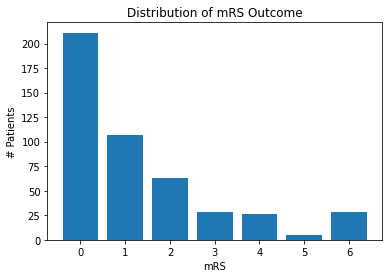

In [6]:
# plot mrs distribution
#dat['mrs_3months'].value_counts(sort=False, ascending = True)
x=[0,1,2,3,4,5,6]
y= [211,107,63,28,26,5,28]
plt.bar(x,y)
plt.ylabel('# Patients')
plt.xlabel('mRS')
plt.title('Distribution of mRS Outcome')
plt.show()

In [7]:
# define mRS binary 
dat.loc[:,"mrs_3months_binary"] = 2
dat.loc[dat.mrs_3months <= 2, "mrs_3months_binary"] = 1

In [8]:
print("number of missing outcomes: {}".format(sum(dat.mrs_3months.isna())))
missing_ids = dat.p_id[dat.mrs_3months.isna()]

#remove all patients with missing outcome
keeps = [not i for i in dat.mrs_3months.isna()]
dat = dat[keeps]

# remove images with missing pat data
pat_id_miss = list(set(pat) - set(dat.p_id))

rem_list = [pat_id_miss, list(missing_ids.values)]
rem_list = [item for sublist in rem_list for item in sublist]

# remove images for missing outcomes
print(X.shape, Y_pat.shape, pat.shape, Y_img.shape)
for i in rem_list :
    X = np.delete(X, np.where(np.array(pat) == int(i))[0], axis = 0)
    Y_pat = np.delete(Y_pat, np.where(np.array(pat) == int(i))[0], axis = 0)
    Y_img = np.delete(Y_img, np.where(np.array(pat) == int(i))[0], axis = 0)
    pat = np.delete(pat, np.where(np.array(pat) == int(i))[0], axis = 0)
    
print(X.shape, Y_pat.shape, pat.shape, Y_img.shape)

number of missing outcomes: 29
(15214, 192, 192, 3) (15214,) (15214,) (15214,)
(13933, 192, 192, 3) (13933,) (13933,) (13933,)


In [9]:
# generate ordinal labels
Y_mrs = np.copy(Y_img)
Y_mrs_ord = np.copy(Y_img)
for i in dat.p_id.values:
    mrs_bin = int(dat[dat['p_id'] == i]['mrs_3months_binary'].values[0])
    mrs_ord  =  int(dat[dat['p_id'] == i]['mrs_3months'].values[0])
    Y_mrs[pat == i] = np.where(Y_mrs[pat == i] == 1, mrs_bin, 0)
    Y_mrs_ord[pat == i] = np.where(Y_mrs_ord[pat == i] == 1, mrs_ord, 0)

    
# sanity checks
print(dat[(dat['event'] == "TIA") & (dat['mrs_3months_binary'] > 0)]['p_id'].shape)
print(dat[(dat['event'] == "Stroke") & (dat['mrs_3months_binary'] > 0)]['p_id'].shape)
print(dat[(dat['event'] == "TIA") & (dat['mrs_3months_binary'] < 1 )]['p_id'].shape)
print(dat[(dat['event'] == "Stroke") & (dat['mrs_3months_binary'] < 1)]['p_id'].shape)

Y_mrs = np.array(Y_mrs)
Y_mrs_ord = np.array(Y_mrs_ord)
print(X.shape, Y_pat.shape, Y_mrs.shape, Y_mrs_ord.shape)

(162,)
(306,)
(0,)
(0,)
(13933, 192, 192, 3) (13933,) (13933,) (13933,)


## 03 Pre-Processing Images

In [10]:
# Get the functions that are used to remove the black images
def get_quantiles(X):
    q1=np.zeros([len(X),3])
    q99=np.zeros([len(X),3])
    for i in range(0,len(X)):
        q1[i]=[np.percentile(X[i,:,:,0],q=1,),np.percentile(X[i,:,:,1],q=1,),np.percentile(X[i,:,:,2],q=1,)]
        q99[i]=[np.percentile(X[i,:,:,0],q=99,),np.percentile(X[i,:,:,1],q=99,),np.percentile(X[i,:,:,2],q=99,)]
    return(q1, q99)

# Function to delete images by index
def delete_by_index(X, Y_img, Y_pat, pat, Y_mrs, Y_mrs_ord, idx):
    X = np.delete(X, idx, axis=0) 
    Y_img = np.delete(Y_img, idx, axis=0)
    pat = np.delete(pat, idx, axis=0)
    Y_mrs = np.delete(Y_mrs, idx, axis=0)
    Y_pat = np.delete(Y_pat, idx, axis=0)
    Y_mrs_ord = np.delete(Y_mrs_ord, idx, axis=0)
    return(X, Y_img, Y_pat, pat, Y_mrs, Y_mrs_ord)

In [11]:
print('Before: ', len(X), len(Y_img), len(Y_pat), len(pat), len(Y_mrs), len(Y_mrs_ord) )

# Get the 1st and 99th quantiles
q1, q99 = get_quantiles(X)
# If the 1st and 99th quantil are similar --> image is black
idx_black_img = np.where(q99[:,0]==q1[:,0])
X, Y_img, Y_pat, pat, Y_mrs , Y_mrs_ord = delete_by_index(X, Y_img, Y_pat, pat, Y_mrs, Y_mrs_ord, idx_black_img)
q1=np.delete(q1, idx_black_img, axis=0) 
q99=np.delete(q99, idx_black_img, axis=0) 

# If the 99th quantile is smaller 10 --> image is black
idx_black_img=np.where((q99[:,0]<10))
X, Y_img, Y_pat, pat, Y_mrs, Y_mrs_ord = delete_by_index(X, Y_img, Y_pat, pat, Y_mrs, Y_mrs_ord, idx_black_img)
q1=np.delete(q1, idx_black_img, axis=0) 
q99=np.delete(q99, idx_black_img, axis=0) 
print('After: ', len(X), len(Y_img), len(Y_pat), len(pat), len(Y_mrs), len(Y_mrs_ord))

Before:  13933 13933 13933 13933 13933 13933
After:  13908 13908 13908 13908 13908 13908


### Normalize images
- For each image we substract it's mean and divide through it's standard deviation

min , max & sd :  32.0 255.0 25.38199


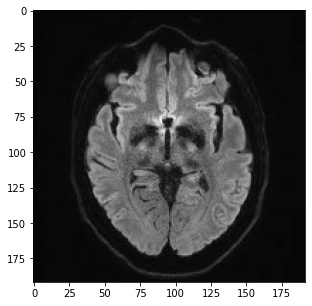

In [12]:
# unnormalized image
n_images = 1
plt.figure(figsize=(5,5))
j = 404
for i in range(n_images):
    fig = plt.subplot(1,n_images,i+1)
    fig.imshow(X[j,:,:,i], cmap = "gray")
print("min , max & sd : ",np.min(X[1]), np.max(X[1]), np.std(X[1]))

In [14]:
def norm_image(X, crop):
    """
    norms an MRI image into size of visible brain area
    returns: list uf cropped/normalized images
    """
    if crop:
        X_crop,thl = cropp_img(X, method = "global")
        X_crop = np.stack(X_crop, axis=0 )
        X_norm = preprocess_input(X_crop, mode='tf')
    else:
        X_1Ch =[]
        for i in range(X[:,:,:,:].shape[0]):
            X_1Ch.append(cv2.cvtColor(X[i,:,:,:],cv2.COLOR_BGR2GRAY).astype(np.float64))
        X_1Ch = np.stack(X_1Ch, axis=0 )
        X_norm = preprocess_input(X_1Ch, mode='tf')
        print(X_norm.shape)
    return X_norm   

# call function
X_norm = norm_image(X, crop = True)
print(X.shape)
print(X_norm.shape)

(13908, 192, 192, 3)
(13908, 192, 192)


Patient ID: 158


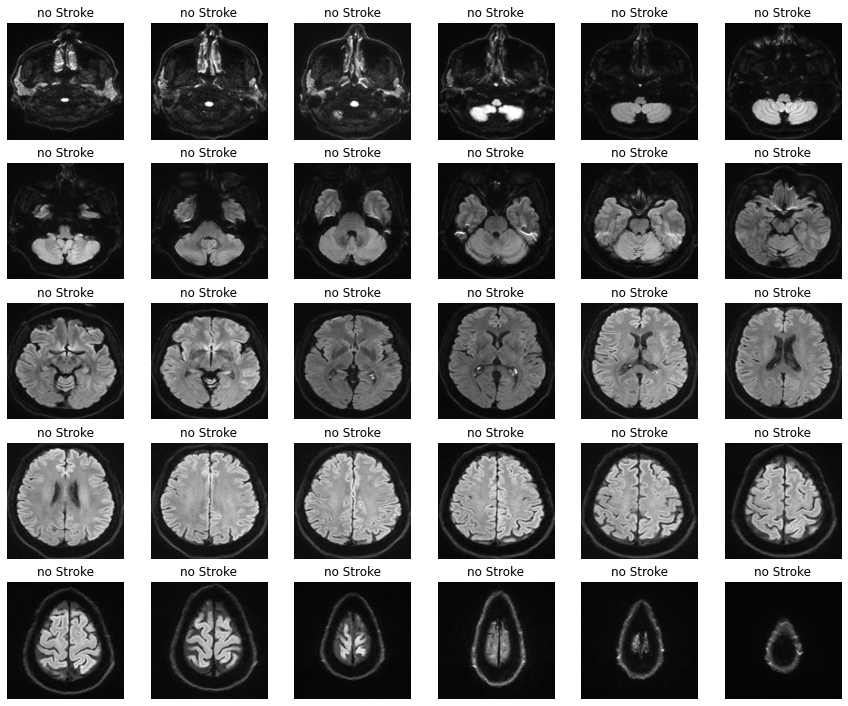

In [15]:
#example for plotting a slices of patient
patid = 158
n_images = len(Y_mrs[np.where(pat == patid)])
plt.figure(figsize=(15,15))
print("Patient ID:", patid)
for i in range(n_images):
    fig = plt.subplot(6,6,i+1)
    fig.imshow(X_norm[np.where(pat == patid)][i], cmap='gray')
    fig.axis('off')
    fig.set_title(Y_mrs[np.where(pat == patid)][i], c = "red")
    if Y_mrs[np.where(pat == patid)][i] > 0:
        fig.set_title("Stroke", c = "red")
    else: 
        fig.set_title("no Stroke", c= "black")    

# 04 Splitting Data


In [16]:
# consider stroke and no-stroke patients separately:
def split_data(X, Y_pat, Y_img, Y_mrs):   
    # stroke patients
    #idx1 = np.where(Y_pat == 1)[0]
    idx1 = np.where(Y_mrs > 0)[0]
    X1 = X[idx1]
    Y1_pat = Y_pat[idx1]
    Y1_img = Y_img[idx1]
    Y1_mrs = Y_mrs[idx1]
    # no stroke patients
    #idx0 = np.where(Y_pat == 0)[0]
    idx0 = np.where(Y_mrs ==0)[0]
    X0 = X[idx0]
    Y0_pat = Y_pat[idx0]
    Y0_img = Y_img[idx0]
    Y0_mrs = Y_mrs[idx0]
    # train test split - Stroke patients:
    X1_train, X1_test, y1_train, y1_test = train_test_split(
        X1, Y1_mrs, test_size=0.20, shuffle = True, random_state=2021)
    # train val split - Stroke patients:
    X1_train, X1_valid, y1_train, y1_valid = train_test_split(
        X1_train, y1_train, test_size=0.25, shuffle = True, random_state=2021)
    print("Stroke patients: ")
    print('train shapes: ', X1_train.shape , y1_train.shape)
    print('validation shapes: ', X1_valid.shape , y1_valid.shape)
    print('test shapes: ', X1_test.shape , y1_test.shape)
    # train test split - noStroke patients:
    X0_train, X0_test, y0_train, y0_test = train_test_split(
        X0, Y0_mrs, test_size=0.20, shuffle = True, random_state=2021)
    # train val split - Stroke patients:
    X0_train, X0_valid, y0_train, y0_valid = train_test_split(
        X0_train, y0_train, test_size=0.25, shuffle = True, random_state=2021)
    print("\nControl: ")
    print('train shapes: ', X0_train.shape , y0_train.shape)
    print('validation shapes: ', X0_valid.shape , y0_valid.shape)
    print('test shapes: ', X0_test.shape , y0_test.shape)   
    #concat train
    X_train = np.concatenate([X1_train , X0_train], axis=0)
    y_train = np.concatenate([y1_train , y0_train], axis=0)
    #concat valid
    X_valid = np.concatenate([X1_valid , X0_valid], axis=0)
    y_valid = np.concatenate([y1_valid , y0_valid], axis=0)
    # concat test
    X_test = np.concatenate([X1_test , X0_test], axis=0)
    y_test = np.concatenate([y1_test , y0_test], axis=0)
    # converto target variable to categorical output
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)
    y_valid = tf.keras.utils.to_categorical(y_valid, num_classes=3)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)
    print('\nMerged shapes:')
    print('train shapes: ', X_train.shape , y_train.shape)
    print('validation shapes: ', X_valid.shape , y_valid.shape)
    print('test shapes: ', X_test.shape , y_test.shape)
    
    return X_train, y_train, X_valid, y_valid, X_test, y_test

    
X_train, y_train, X_valid, y_valid, X_test, y_test = split_data(X_norm, Y_pat, Y_img,Y_mrs)

Stroke patients: 
train shapes:  (1775, 192, 192) (1775,)
validation shapes:  (592, 192, 192) (592,)
test shapes:  (592, 192, 192) (592,)

Control: 
train shapes:  (6569, 192, 192) (6569,)
validation shapes:  (2190, 192, 192) (2190,)
test shapes:  (2190, 192, 192) (2190,)

Merged shapes:
train shapes:  (8344, 192, 192) (8344, 3)
validation shapes:  (2782, 192, 192) (2782, 3)
test shapes:  (2782, 192, 192) (2782, 3)


# 05 Load mRS Model

In [17]:
model_mrs = keras.models.load_model('/tf/notebooks/avci/XAI/mrs/2021_06_26_10_06_43/checkpoints/342-0.25.hdf5')
model_mrs.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 192, 192, 32)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 192, 192, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 192, 192, 32)      0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 96, 96, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 96, 96, 64)       

In [18]:
# code for plotting models
#! pip install pydot
#! pip install pydotplus
#! apt-get install graphviz -y
#
#import pydot
#from tensorflow.keras.utils import plot_model 
#plot_model(
#    model_mrs, to_file='model_ordinal.jpg', show_shapes=True,
#    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
#)

In [19]:
X_test = np.expand_dims(X_test, axis = 3)
X_test.shape

(2782, 192, 192, 1)

In [20]:
# get performance metrics
from sklearn.metrics import classification_report, confusion_matrix
from statsmodels.stats.proportion import proportion_confint

y_pred = model_mrs.predict(X_test)
# NLL
NLL, Acc = model_mrs.evaluate( x=X_test, y=y_test, verbose=0)
# cm 
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis =1))
#acc
nobs = sum(sum(cm))
count = sum([cm[0,0], cm[1,1]], cm[2,2])
acc_ci_low, acc_ci_upp = proportion_confint(count , nobs,  alpha=0.05, method='wilson')
#acc 0
nobs = sum(cm[0,])
count = cm[0,0]
acc0 = count/nobs
acc0_ci_low, acc0_ci_upp = proportion_confint(count , nobs,  alpha=0.05, method='wilson')
#acc 1
nobs = sum(cm[1,])
count = cm[1,1]
acc1 = count/nobs
acc1_ci_low, acc1_ci_upp = proportion_confint(count , nobs,  alpha=0.05, method='wilson')
#acc 2
nobs = sum(cm[2,])
count = cm[2,2]
acc2 = count/nobs
acc2_ci_low, acc2_ci_upp = proportion_confint(count , nobs,  alpha=0.05, method='wilson')
print("\nPerformance on Test Set : ")
print("\nAccuracy         [95% Conf.] :", np.around(Acc,4),np.around([acc_ci_low, acc_ci_upp],4))
print("Accuracy Class 0 [95% Conf.] :", np.around(acc0,4),np.around([acc0_ci_low, acc0_ci_upp],4))
print("Accuracy Class 1 [95% Conf.] :", np.around(acc1,4),np.around([acc1_ci_low, acc1_ci_upp],4))
print("Accuracy Class 2 [95% Conf.] :", np.around(acc2,4),np.around([acc2_ci_low, acc2_ci_upp],4))
print("Negative Log-Likelihood      :", np.around(NLL, 4))


Performance on Test Set : 

Accuracy         [95% Conf.] : 0.9206 [0.9099 0.93  ]
Accuracy Class 0 [95% Conf.] : 0.9909 [0.9859 0.9941]
Accuracy Class 1 [95% Conf.] : 0.7018 [0.6545 0.7451]
Accuracy Class 2 [95% Conf.] : 0.5813 [0.5125 0.647 ]
Negative Log-Likelihood      : 0.2329


# 06 Load Stroke Model 

In [21]:
model_stroke = keras.models.load_model('/tf/notebooks/avci/XAI/stroke/noCV/2021-05-14 14:00:42.417988/checkpoints/96-0.21.hdf5')
model_stroke.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 192, 192, 32)      320       
_________________________________________________________________
batch_normalization_12 (Batc (None, 192, 192, 32)      128       
_________________________________________________________________
activation_12 (Activation)   (None, 192, 192, 32)      0         
_________________________________________________________________
average_pooling2d_11 (Averag (None, 96, 96, 32)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 96, 96, 64)        18496     
_________________________________________________________________
batch_normalization_13 (Batc (None, 96, 96, 64)       

# 07 Individual Predictions 

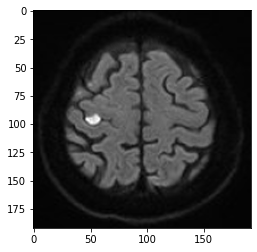

MRS Prediction Probability: [3.4578081e-06 5.0017107e-01 4.9982548e-01]
MRS Prediction : 1
Stroke Prediction Probability: [0. 1.]
Stroke Prediction : 1


In [22]:
# example for single predictions
img = X_norm[pat == 6][23].reshape(192,192,1)
plt.imshow(img.reshape(192,192), cmap="gray")
plt.show()
img = np.expand_dims(img,axis=0)
predictions = model_mrs.predict(img)
print("MRS Prediction Probability:" ,predictions[0])
print("MRS Prediction :" ,np.argmax(predictions))
predictions = model_stroke.predict(img)
print("Stroke Prediction Probability:" ,np.round(predictions[0],4))
print("Stroke Prediction :" ,np.argmax(predictions))

# 08 Grad CAMs Stroke Model


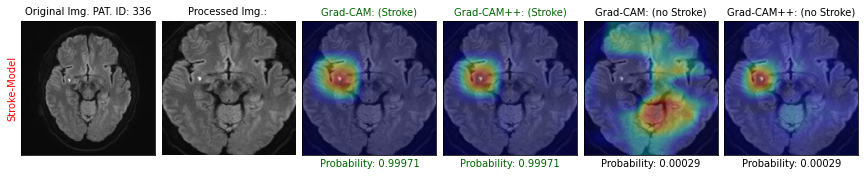

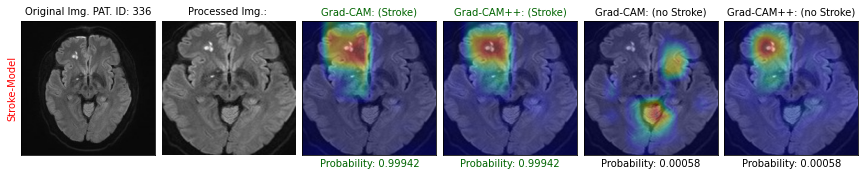

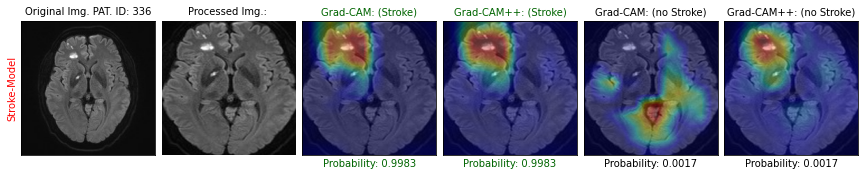

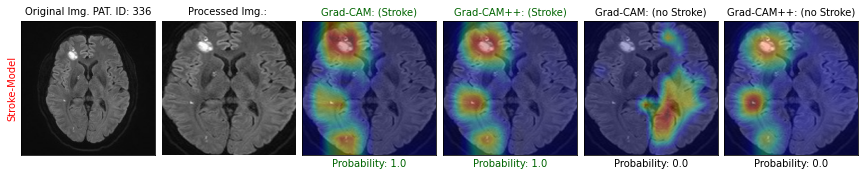

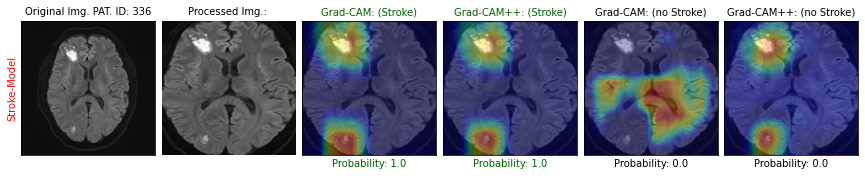

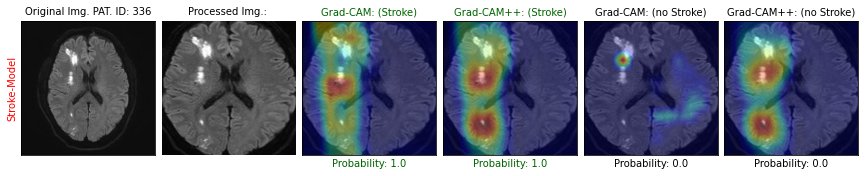

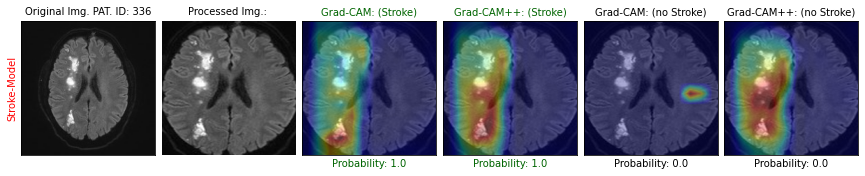

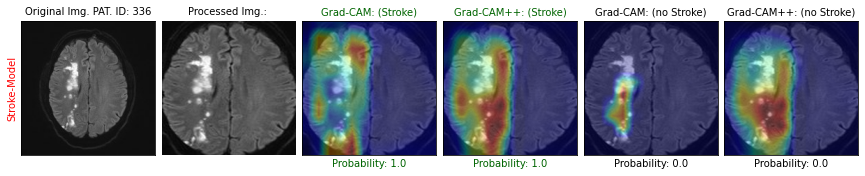

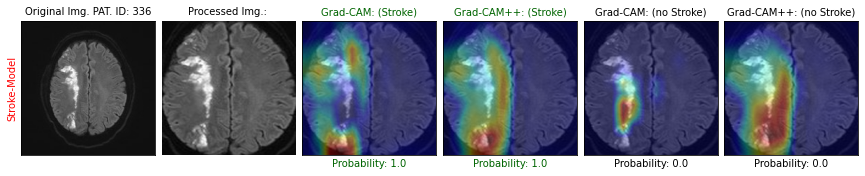

In [23]:
layer_stroke= 'activation_16'
str_label = 1
np.set_printoptions(suppress=True) 
N = 20
p= 336
X_list = X[list(set(np.where(pat == p)[0]))][0:N]
X_list_n = X_norm[list(set(np.where(pat == p)[0]))][0:N]
stroke_label = Y_img[list(set(np.where(pat == p)[0]))][0:N]
pid = pat[list(set(np.where(pat == p)[0]))][0:N]

for im , im_n , str_l ,pid in zip(X_list , X_list_n, stroke_label,pid):
    orig_img = im.astype(np.uint8)
    img = im_n.reshape(192,192,1)
    img = np.expand_dims(img,axis=0)
    # stroke pred
    predictions_stroke = model_stroke.predict(img)
    # plot only if mrs pred is "confident"
    if (np.argmax(predictions_stroke) == 1) & (predictions_stroke[0][1] > 0.9) :
        prob_stroke = np.around(predictions_stroke[0],5)
        # remove softmax layer
        model_stroke.layers[-1].activation = None
        
        # plot Original image
        plt.figure(figsize=(15,15))
        plt.subplot(1,6,1)
        plt.title("Original Img. " +"PAT. ID: " + str(pid) , fontsize=10)#;
        plt.ylabel("Stroke-Model", color = "red");plt.xticks([], []);plt.yticks([], [])        
        plt.imshow(orig_img, cmap="gray")
        
        # plot proc image        
        plt.subplot(1,6,2)
        plt.title("Processed Img.: " , fontsize=10);plt.axis('off')
        plt.imshow(img.reshape(192,192), cmap="gray")
        
        # ---- Stroke / TIA ----
        # plot Grad-CAM 1
        cam = make_gradcam_heatmap(img, model_stroke, last_conv_layer_name = layer_stroke, pred_index = 1)
        plt.subplot(1,6,3)
        plt.title("Grad-CAM: (Stroke)", fontsize=10, color= "darkgreen")
        plt.xlabel("Probability: " +str(prob_stroke[1]), color = "darkgreen");plt.xticks([], []);plt.yticks([], [])        
        plt.imshow(img.reshape(192,192) , cmap = "gray")
        plt.imshow(cam.reshape(192,192),alpha=1/3,cmap="jet")
        
        # plot Grad CAM ++ 1
        cam = grad_cam_plus(model_stroke, img, layer_name=layer_stroke,category_id=1)
        plt.subplot(1,6,4)
        plt.title("Grad-CAM++: (Stroke)", fontsize=10, color= "darkgreen")
        plt.xlabel("Probability: " +str(prob_stroke[1]), color = "darkgreen");plt.xticks([], []);plt.yticks([], [])        
        plt.imshow(img.reshape(192,192) , cmap = "gray")
        plt.imshow(cam.reshape(192,192),alpha=1/3,cmap="jet")
        
        # plot Grad-CAM 0
        cam = make_gradcam_heatmap(img, model_stroke, last_conv_layer_name = layer_stroke, pred_index = 0)
        plt.subplot(1,6,5)
        plt.title("Grad-CAM: (no Stroke)",color= "k", fontsize=10)
        plt.xlabel("Probability: " +str(prob_stroke[0]), color = "k");plt.xticks([], []);plt.yticks([], [])        
        plt.imshow(img.reshape(192,192) , cmap = "gray")
        plt.imshow(cam.reshape(192,192),alpha=1/3,cmap="jet")
        
        # plot Grad CAM ++ 0
        cam = grad_cam_plus(model_stroke, img, layer_name=layer_stroke,category_id=0)
        plt.subplot(1,6,6)
        plt.title("Grad-CAM++: (no Stroke)",color= "k", fontsize=10)
        plt.xlabel("Probability: " +str(prob_stroke[0]), color = "k");plt.xticks([], []);plt.yticks([], [])        
        plt.imshow(img.reshape(192,192) , cmap = "gray")
        plt.imshow(cam.reshape(192,192),alpha=1/3,cmap="jet")
        plt.subplots_adjust(top = 0.35, bottom=0.01,hspace=0.01, wspace=0.05)
        plt.show();

# 09 Grad CAMs Stroke Model and mRS Model


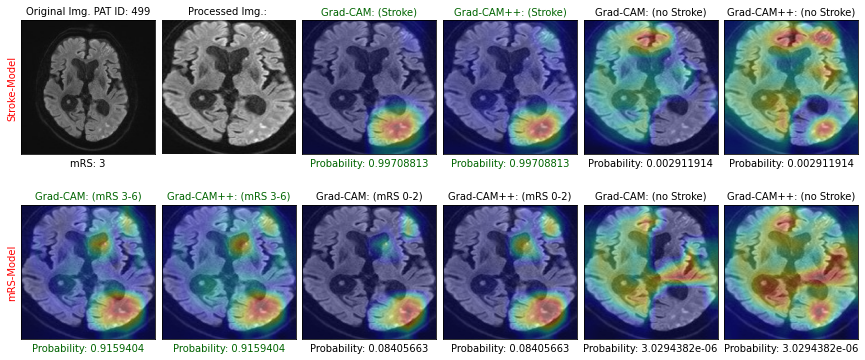

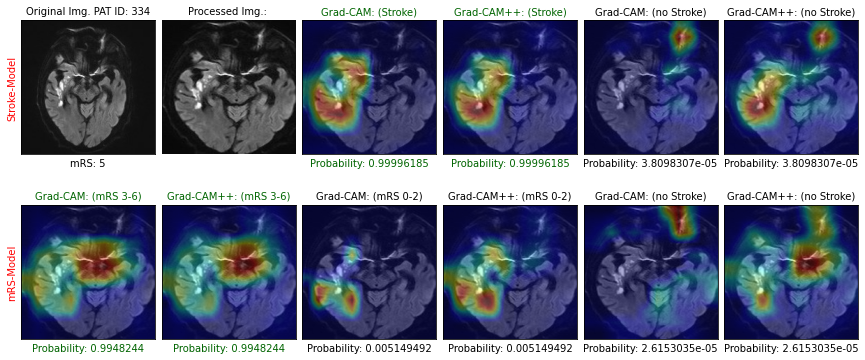

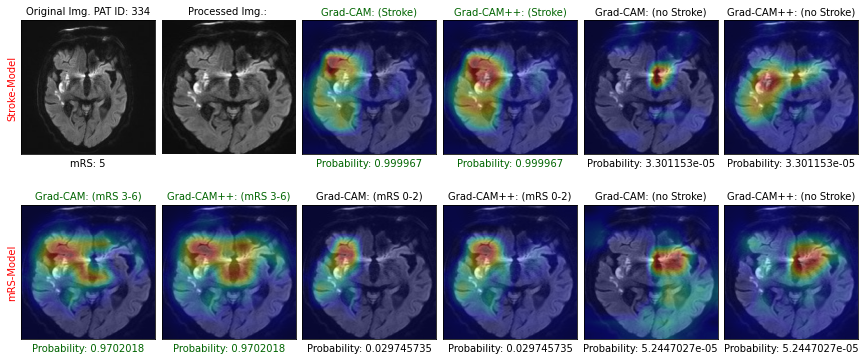

In [24]:
# FOR OUTCOME mRS  3-6
layer = 'activation_5' # conv2d_5
layer_stroke= 'activation_16'
mrs_label = 2
str_label = 1
np.set_printoptions(suppress=True) 
N = 40

X_list = X[list(set(np.where(Y_mrs == mrs_label)[0]) 
               & set(np.where(Y_img == str_label)[0]))][0:N]
X_list_n = X_norm[list(set(np.where(Y_mrs == mrs_label)[0]) 
               & set(np.where(Y_img == str_label)[0]))][0:N]
ord_label = Y_mrs_ord[list(set(np.where(Y_mrs == mrs_label)[0]) 
               & set(np.where(Y_img == str_label)[0]))][0:N]
stroke_label = Y_img[list(set(np.where(Y_mrs == mrs_label)[0]) 
               & set(np.where(Y_img == str_label)[0]))][0:N]

pid = pat[list(set(np.where(Y_mrs == mrs_label)[0]) 
               & set(np.where(Y_img == str_label)[0]))][0:N]

for im , im_n, ord_l , str_l ,pid in zip(X_list , X_list_n, ord_label, stroke_label,pid):
    orig_img = im.astype(np.uint8)
    img = im_n.reshape(192,192,1)
    img = np.expand_dims(img,axis=0)
    # mrs pred
    predictions = model_mrs.predict(img)
    # stroke pred
    predictions_stroke = model_stroke.predict(img)
    # plot only if mrs pred is "confident"
    if (np.argmax(predictions) > 0) & (predictions[0][2] > 0.90):
        
        if np.argmax(predictions) == 2:
            pred_str = str('3-6')
        elif np.argmax(predictions) == 1:
            pred_str = str('0-2')
        else:
            pred_str = str('no Stroke')
        # remove softmax layer
        model_mrs.layers[-1].activation = None
        model_stroke.layers[-1].activation = None
        
        # plot Original image
        plt.figure(figsize=(15,15))
        plt.subplot(2,6,1)
        plt.title("Original Img. PAT ID: " + str(pid), fontsize=10)#;
        plt.ylabel("Stroke-Model", color = "red");plt.xticks([], []);plt.yticks([], [])      
        plt.xlabel("mRS: " + str(ord_l))
        plt.imshow(orig_img, cmap="gray")
        
        # plot proc image        
        plt.subplot(2,6,2)
        plt.title("Processed Img.: " , fontsize=10);plt.axis('off')
        plt.imshow(img.reshape(192,192), cmap="gray")
        
        # ---- Stroke / TIA ----
        # plot Grad-CAM 1
        cam = make_gradcam_heatmap(img, model_stroke, last_conv_layer_name = layer_stroke, pred_index = 1)
        plt.subplot(2,6,3)
        plt.title("Grad-CAM: (Stroke)" , fontsize=10, color= "darkgreen")
        plt.xlabel("Probability: " +str(predictions_stroke[0][1]), color = "darkgreen");plt.xticks([], []);plt.yticks([], [])        
        plt.imshow(img.reshape(192,192) , cmap = "gray")
        plt.imshow(cam.reshape(192,192),alpha=1/3,cmap="jet")
        
        # plot Grad CAM ++ 1
        cam = grad_cam_plus(model_stroke, img, layer_name=layer_stroke,category_id=1)
        plt.subplot(2,6,4)
        plt.title("Grad-CAM++: (Stroke)", fontsize=10, color= "darkgreen")
        plt.xlabel("Probability: " +str(predictions_stroke[0][1]), color = "darkgreen");plt.xticks([], []);plt.yticks([], [])        
        plt.imshow(img.reshape(192,192) , cmap = "gray")
        plt.imshow(cam.reshape(192,192),alpha=1/3,cmap="jet")
        
        # plot Grad-CAM 0
        cam = make_gradcam_heatmap(img, model_stroke, last_conv_layer_name = layer_stroke, pred_index = 0)
        plt.subplot(2,6,5)
        plt.title("Grad-CAM: (no Stroke)", fontsize=10)
        plt.xlabel("Probability: " +str(predictions_stroke[0][0]), color = "k");plt.xticks([], []);plt.yticks([], [])        
        plt.imshow(img.reshape(192,192) , cmap = "gray")
        plt.imshow(cam.reshape(192,192),alpha=1/3,cmap="jet")
        
        # plot Grad CAM ++ 0
        cam = grad_cam_plus(model_stroke, img, layer_name=layer_stroke,category_id=0)
        plt.subplot(2,6,6)
        plt.title("Grad-CAM++: (no Stroke)", fontsize=10)
        plt.xlabel("Probability: " +str(predictions_stroke[0][0]), color = "k");plt.xticks([], []);plt.yticks([], [])        
        plt.imshow(img.reshape(192,192) , cmap = "gray")
        plt.imshow(cam.reshape(192,192),alpha=1/3,cmap="jet")
        
        # ---- MRS ----
        # plot Grad-CAM 2
        cam = make_gradcam_heatmap(img, model_mrs, last_conv_layer_name = layer, pred_index = 2)
        plt.subplot(2,6,7)
        plt.title("Grad-CAM: (mRS 3-6)", fontsize=10, color= "darkgreen")                
        plt.ylabel("mRS-Model", color = "red")
        plt.xlabel("Probability: " +str(predictions[0][2]), color = "darkgreen");plt.xticks([], []);plt.yticks([], [])        
        #;plt.axis('off')
        plt.imshow(img.reshape(192,192) , cmap = "gray")
        plt.imshow(cam.reshape(192,192),alpha=1/3,cmap="jet")
        
        # plot Grad CAM ++ 2
        cam = grad_cam_plus(model_mrs, img, layer_name=layer,category_id=2)
        plt.subplot(2,6,8)
        plt.title("Grad-CAM++: (mRS 3-6)", fontsize=10,  color= "darkgreen")
        plt.xlabel("Probability: " +str(predictions[0][2]), color = "darkgreen");plt.xticks([], []);plt.yticks([], [])        
        plt.imshow(img.reshape(192,192) , cmap = "gray")
        plt.imshow(cam.reshape(192,192),alpha=1/3,cmap="jet")
        
        # plot Grad-CAM 1
        cam = make_gradcam_heatmap(img, model_mrs, last_conv_layer_name = layer, pred_index = 1)
        plt.subplot(2,6,9)
        plt.title("Grad-CAM: (mRS 0-2)", fontsize=10)
        plt.xlabel("Probability: " +str(predictions[0][1]), color = "k");plt.xticks([], []);plt.yticks([], [])        
        plt.imshow(img.reshape(192,192) , cmap = "gray")
        plt.imshow(cam.reshape(192,192),alpha=1/3,cmap="jet")
        
        # plot Grad CAM ++ 1
        cam = grad_cam_plus(model_mrs, img, layer_name=layer,category_id=1)
        plt.subplot(2,6,10)
        plt.title("Grad-CAM++: (mRS 0-2)", fontsize=10)
        plt.xlabel("Probability: " +str(predictions[0][1]), color = "k");plt.xticks([], []);plt.yticks([], [])        
        plt.imshow(img.reshape(192,192) , cmap = "gray")
        plt.imshow(cam.reshape(192,192),alpha=1/3,cmap="jet")        
        
        # plot Grad-CAM 0
        cam = make_gradcam_heatmap(img, model_mrs, last_conv_layer_name = layer, pred_index = 0)
        plt.subplot(2,6,11)
        plt.title("Grad-CAM: (no Stroke)", fontsize=10)
        plt.xlabel("Probability: " +str(predictions[0][0]), color = "k");plt.xticks([], []);plt.yticks([], [])        
        plt.imshow(img.reshape(192,192) , cmap = "gray")
        plt.imshow(cam.reshape(192,192),alpha=1/3,cmap="jet")
        
        # plot Grad CAM ++ 0
        cam = grad_cam_plus(model_mrs, img, layer_name=layer,category_id=0)
        plt.subplot(2,6,12)
        plt.title("Grad-CAM++: (no Stroke)", fontsize=10)
        plt.xlabel("Probability: " +str(predictions[0][0]), color = "k");plt.xticks([], []);plt.yticks([], [])        
        plt.imshow(img.reshape(192,192) , cmap = "gray")
        plt.imshow(cam.reshape(192,192),alpha=1/3,cmap="jet")
                
        plt.subplots_adjust(top = 0.35, bottom=0.01,hspace=0.01, wspace=0.05)
        plt.show();

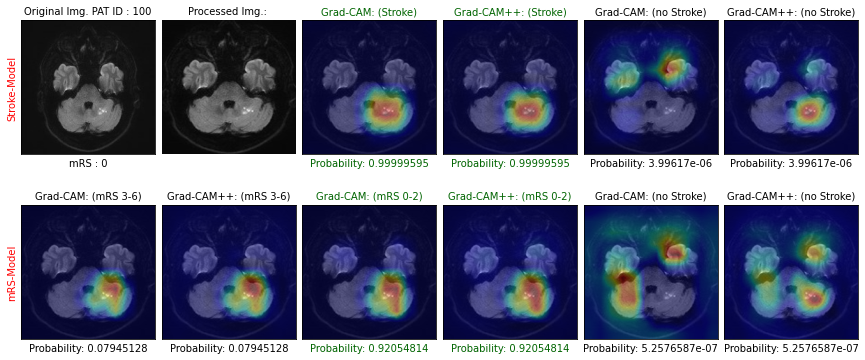

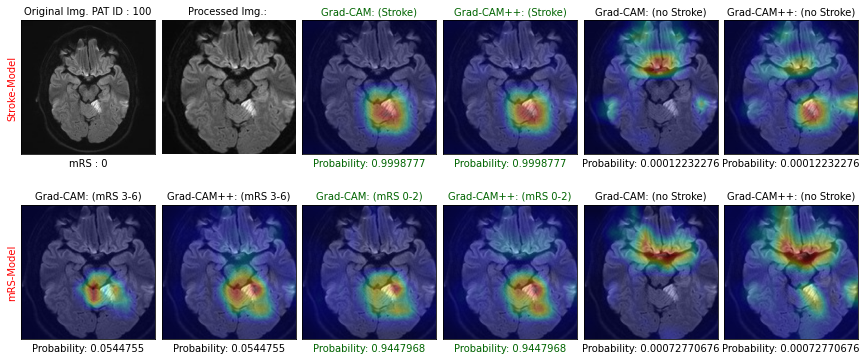

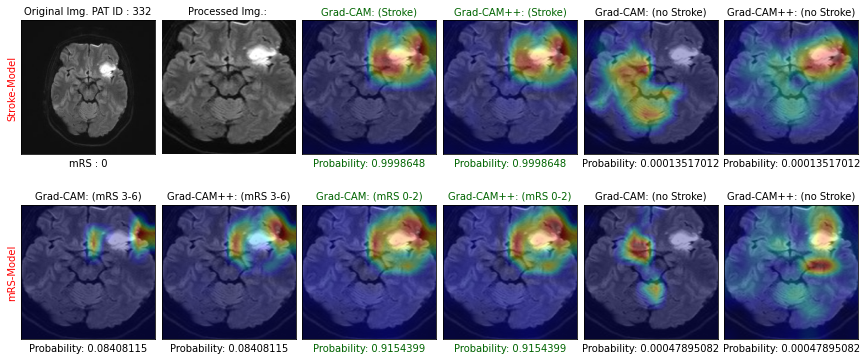

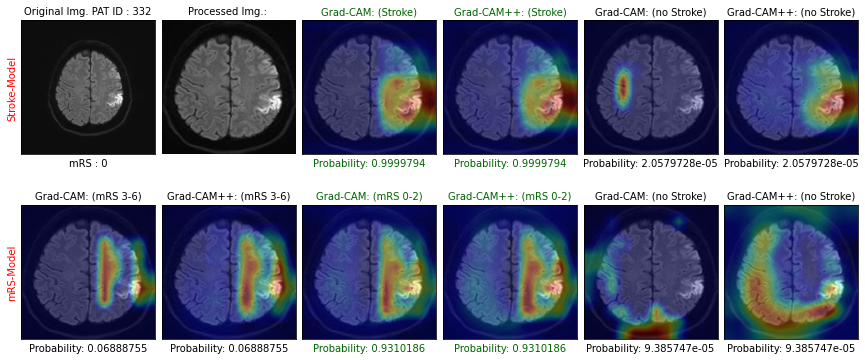

In [25]:
# FROR OUTCOME mRS  0-2
layer = 'activation_5' # conv2d_5
layer_stroke= 'activation_16'
mrs_label = 1
str_label = 1
np.set_printoptions(suppress=True) 
N = 20

X_list = X[list(set(np.where(Y_mrs == mrs_label)[0]) 
               & set(np.where(Y_img == str_label)[0]))][0:N]
X_list_n = X_norm[list(set(np.where(Y_mrs == mrs_label)[0]) 
               & set(np.where(Y_img == str_label)[0]))][0:N]
ord_label = Y_mrs_ord[list(set(np.where(Y_mrs == mrs_label)[0]) 
               & set(np.where(Y_img == str_label)[0]))][0:N]
stroke_label = Y_img[list(set(np.where(Y_mrs == mrs_label)[0]) 
               & set(np.where(Y_img == str_label)[0]))][0:N]

pid = pat[list(set(np.where(Y_mrs == mrs_label)[0]) 
               & set(np.where(Y_img == str_label)[0]))][0:N]

for im , im_n, ord_l , str_l ,pid in zip(X_list , X_list_n, ord_label, stroke_label,pid):
    orig_img = im.astype(np.uint8)
    img = im_n.reshape(192,192,1)
    img = np.expand_dims(img,axis=0)
    # mrs pred
    predictions = model_mrs.predict(img)
    # stroke pred
    predictions_stroke = model_stroke.predict(img)
    # plot only if mrs pred is "confident"
    if (np.argmax(predictions) > 0) & (predictions[0][1] > 0.90):
        
        if np.argmax(predictions) == 2:
            pred_str = str('3-6')
        elif np.argmax(predictions) == 1:
            pred_str = str('0-2')
        else:
            pred_str = str('no Stroke')

        # remove softmax layer
        model_mrs.layers[-1].activation = None
        model_stroke.layers[-1].activation = None
        
        # plot Original image
        plt.figure(figsize=(15,15))
        plt.subplot(2,6,1)
        plt.title("Original Img. PAT ID : " +str(pid) , fontsize=10)#;
        plt.ylabel("Stroke-Model", color = "red")
        plt.xlabel("mRS : " + str(ord_l));plt.xticks([], []);plt.yticks([], [])        
        plt.imshow(orig_img, cmap="gray")
        
        # plot proc image        
        plt.subplot(2,6,2)
        plt.title("Processed Img.: " , fontsize=10);plt.axis('off')
        plt.imshow(img.reshape(192,192), cmap="gray")
        
        
        # ---- Stroke / TIA ----
        # plot Grad-CAM 1
        cam = make_gradcam_heatmap(img, model_stroke, last_conv_layer_name = layer_stroke, pred_index = 1)
        plt.subplot(2,6,3)
        plt.title("Grad-CAM: (Stroke)", fontsize=10, color= "darkgreen")
        plt.xlabel("Probability: " +str(predictions_stroke[0][1]), color = "darkgreen");plt.xticks([], []);plt.yticks([], [])   
        plt.imshow(img.reshape(192,192) , cmap = "gray")
        plt.imshow(cam.reshape(192,192),alpha=1/3,cmap="jet")
        
        # plot Grad CAM ++ 1
        cam = grad_cam_plus(model_stroke, img, layer_name=layer_stroke,category_id=1)
        plt.subplot(2,6,4)
        plt.title("Grad-CAM++: (Stroke)", fontsize=10, color= "darkgreen")
        plt.xlabel("Probability: " +str(predictions_stroke[0][1]), color = "darkgreen");plt.xticks([], []);plt.yticks([], [])   
        plt.imshow(img.reshape(192,192) , cmap = "gray")
        plt.imshow(cam.reshape(192,192),alpha=1/3,cmap="jet")
        
        # plot Grad-CAM 0
        cam = make_gradcam_heatmap(img, model_stroke, last_conv_layer_name = layer_stroke, pred_index = 0)
        plt.subplot(2,6,5)
        plt.title("Grad-CAM: (no Stroke)", fontsize=10)
        plt.xlabel("Probability: " +str(predictions_stroke[0][0]), color = "k");plt.xticks([], []);plt.yticks([], [])   
        plt.imshow(img.reshape(192,192) , cmap = "gray")
        plt.imshow(cam.reshape(192,192),alpha=1/3,cmap="jet")
        
        # plot Grad CAM ++ 0
        cam = grad_cam_plus(model_stroke, img, layer_name=layer_stroke,category_id=0)
        plt.subplot(2,6,6)
        plt.title("Grad-CAM++: (no Stroke)", fontsize=10)
        plt.xlabel("Probability: " +str(predictions_stroke[0][0]), color = "k");plt.xticks([], []);plt.yticks([], [])   
        plt.imshow(img.reshape(192,192) , cmap = "gray")
        plt.imshow(cam.reshape(192,192),alpha=1/3,cmap="jet")
        
        # ---- MRS ----
        # plot Grad-CAM 2
        cam = make_gradcam_heatmap(img, model_mrs, last_conv_layer_name = layer, pred_index = 2)
        plt.subplot(2,6,7)
        plt.title("Grad-CAM: (mRS 3-6)", fontsize=10)                
        plt.ylabel("mRS-Model", color = "red")
        plt.xlabel("Probability: " +str(predictions[0][2]), color = "k");plt.xticks([], []);plt.yticks([], [])        
        #;plt.axis('off')
        plt.imshow(img.reshape(192,192) , cmap = "gray")
        plt.imshow(cam.reshape(192,192),alpha=1/3,cmap="jet")
        
        # plot Grad CAM ++ 2
        cam = grad_cam_plus(model_mrs, img, layer_name=layer,category_id=2)
        plt.subplot(2,6,8)
        plt.title("Grad-CAM++: (mRS 3-6)", fontsize=10)
        plt.xlabel("Probability: " +str(predictions[0][2]), color = "k");plt.xticks([], []);plt.yticks([], [])        
        plt.imshow(img.reshape(192,192) , cmap = "gray")
        plt.imshow(cam.reshape(192,192),alpha=1/3,cmap="jet")
        
        # plot Grad-CAM 1
        cam = make_gradcam_heatmap(img, model_mrs, last_conv_layer_name = layer, pred_index = 1)
        plt.subplot(2,6,9)
        plt.title("Grad-CAM: (mRS 0-2)", fontsize=10,  color= "darkgreen")
        plt.xlabel("Probability: " +str(predictions[0][1]), color = "darkgreen");plt.xticks([], []);plt.yticks([], [])        
        plt.imshow(img.reshape(192,192) , cmap = "gray")
        plt.imshow(cam.reshape(192,192),alpha=1/3,cmap="jet")
        
        # plot Grad CAM ++ 1
        cam = grad_cam_plus(model_mrs, img, layer_name=layer,category_id=1)
        plt.subplot(2,6,10)
        plt.title("Grad-CAM++: (mRS 0-2)", fontsize=10,  color= "darkgreen")
        plt.xlabel("Probability: " +str(predictions[0][1]), color = "darkgreen");plt.xticks([], []);plt.yticks([], [])        
        plt.imshow(img.reshape(192,192) , cmap = "gray")
        plt.imshow(cam.reshape(192,192),alpha=1/3,cmap="jet")        
        
        # plot Grad-CAM 0
        cam = make_gradcam_heatmap(img, model_mrs, last_conv_layer_name = layer, pred_index = 0)
        plt.subplot(2,6,11)
        plt.title("Grad-CAM: (no Stroke)", fontsize=10)
        plt.xlabel("Probability: " +str(predictions[0][0]), color = "k");plt.xticks([], []);plt.yticks([], [])        
        plt.imshow(img.reshape(192,192) , cmap = "gray")
        plt.imshow(cam.reshape(192,192),alpha=1/3,cmap="jet")
        
        # plot Grad CAM ++ 0
        cam = grad_cam_plus(model_mrs, img, layer_name=layer,category_id=0)
        plt.subplot(2,6,12)
        plt.title("Grad-CAM++: (no Stroke)", fontsize=10)
        plt.xlabel("Probability: " +str(predictions[0][0]), color = "k");plt.xticks([], []);plt.yticks([], [])        
        plt.imshow(img.reshape(192,192) , cmap = "gray")
        plt.imshow(cam.reshape(192,192),alpha=1/3,cmap="jet")
                
        plt.subplots_adjust(top = 0.35, bottom=0.01,hspace=0.01, wspace=0.05)
        plt.show();


PAT. ID: 341  mRS: 0  Stroke: 0

Stroke Probability: [0.89403 0.10597]
Stroke Prediction : 0
mRS Probability: [1. 0. 0.]
mRS Prediction : no Stroke


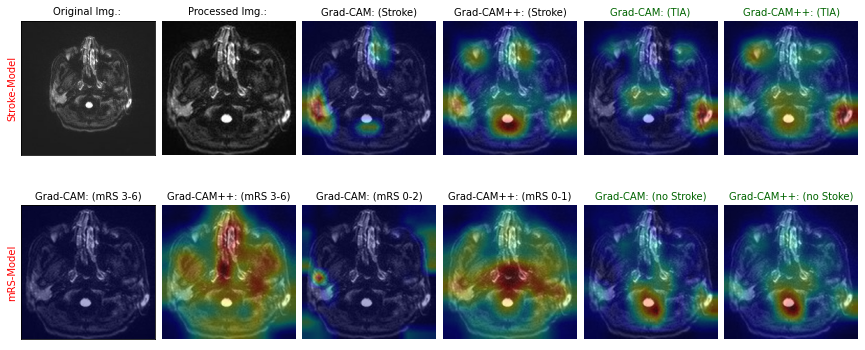

In [26]:
# FROR OUTCOME no Stroke
layer = 'activation_5' # conv2d_5
layer_stroke= 'activation_16'
mrs_label = 0
str_label = 0
np.set_printoptions(suppress=True) 
N = 1

X_list = X[list(set(np.where(Y_mrs == mrs_label)[0]) 
               & set(np.where(Y_pat == str_label)[0]))][0:N]
X_list_n = X_norm[list(set(np.where(Y_mrs == mrs_label)[0]) 
               & set(np.where(Y_pat == str_label)[0]))][0:N]
ord_label = Y_mrs_ord[list(set(np.where(Y_mrs == mrs_label)[0]) 
               & set(np.where(Y_pat == str_label)[0]))][0:N]
stroke_label = Y_img[list(set(np.where(Y_mrs == mrs_label)[0]) 
               & set(np.where(Y_pat == str_label)[0]))][0:N]

pid = pat[list(set(np.where(Y_mrs == mrs_label)[0]) 
               & set(np.where(Y_pat == str_label)[0]))][0:N]

for im , im_n, ord_l , str_l ,pid in zip(X_list , X_list_n, ord_label, stroke_label,pid):
    orig_img = im.astype(np.uint8)
    img = im_n.reshape(192,192,1)
    img = np.expand_dims(img,axis=0)
    # mrs pred
    predictions = model_mrs.predict(img)
    # stroke pred
    predictions_stroke = model_stroke.predict(img)
    # plot only if mrs pred is "confident"
    if (np.argmax(predictions) == 0) & (predictions[0][0] > 0.90):
        
        if np.argmax(predictions) == 2:
            pred_str = str('3-6')
        elif np.argmax(predictions) == 1:
            pred_str = str('0-2')
        else:
            pred_str = str('no Stroke')
            
        print("PAT. ID:",pid, " mRS:",str(ord_l), " Stroke:", str(str_l) )
        print("\nStroke Probability:" ,np.around(predictions_stroke[0],5))
        print("Stroke Prediction :" ,np.argmax(predictions_stroke))
        print("mRS Probability:" ,np.around(predictions[0],5))
        print("mRS Prediction :" ,pred_str)

        # remove softmax layer
        model_mrs.layers[-1].activation = None
        model_stroke.layers[-1].activation = None
        
        # plot Original image
        plt.figure(figsize=(15,15))
        plt.subplot(2,6,1)
        plt.title("Original Img.: " , fontsize=10)#;
        plt.ylabel("Stroke-Model", color = "red");plt.xticks([], []);plt.yticks([], [])        
        plt.imshow(orig_img, cmap="gray")
        
        # plot proc image        
        plt.subplot(2,6,2)
        plt.title("Processed Img.: " , fontsize=10);plt.axis('off')
        plt.imshow(img.reshape(192,192), cmap="gray")
        
        
        # ---- Stroke / TIA ----
        # plot Grad-CAM 1
        cam = make_gradcam_heatmap(img, model_stroke, last_conv_layer_name = layer_stroke, pred_index = 1)
        plt.subplot(2,6,3)
        plt.title("Grad-CAM: (Stroke)", fontsize=10);plt.axis('off')
        plt.imshow(img.reshape(192,192) , cmap = "gray")
        plt.imshow(cam.reshape(192,192),alpha=1/3,cmap="jet")
        
        # plot Grad CAM ++ 1
        cam = grad_cam_plus(model_stroke, img, layer_name=layer_stroke,category_id=1)
        plt.subplot(2,6,4)
        plt.title("Grad-CAM++: (Stroke)", fontsize=10);plt.axis('off')
        plt.imshow(img.reshape(192,192) , cmap = "gray")
        plt.imshow(cam.reshape(192,192),alpha=1/3,cmap="jet")
        
        # plot Grad-CAM 0
        cam = make_gradcam_heatmap(img, model_stroke, last_conv_layer_name = layer_stroke, pred_index = 0)
        plt.subplot(2,6,5)
        plt.title("Grad-CAM: (TIA)", fontsize=10,color= "darkgreen");plt.axis('off')
        plt.imshow(img.reshape(192,192) , cmap = "gray")
        plt.imshow(cam.reshape(192,192),alpha=1/3,cmap="jet")
        
        # plot Grad CAM ++ 0
        cam = grad_cam_plus(model_stroke, img, layer_name=layer_stroke,category_id=0)
        plt.subplot(2,6,6)
        plt.title("Grad-CAM++: (TIA)", fontsize=10,color= "darkgreen");plt.axis('off')
        plt.imshow(img.reshape(192,192) , cmap = "gray")
        plt.imshow(cam.reshape(192,192),alpha=1/3,cmap="jet")
        
        # ---- MRS ----
        # plot Grad-CAM 2
        cam = make_gradcam_heatmap(img, model_mrs, last_conv_layer_name = layer, pred_index = 2)
        plt.subplot(2,6,7)
        plt.title("Grad-CAM: (mRS 3-6)", fontsize=10)                
        plt.ylabel("mRS-Model", color = "red");plt.xticks([], []);plt.yticks([], [])        
        #;plt.axis('off')
        plt.imshow(img.reshape(192,192) , cmap = "gray")
        plt.imshow(cam.reshape(192,192),alpha=1/3,cmap="jet")
        
        # plot Grad CAM ++ 2
        cam = grad_cam_plus(model_mrs, img, layer_name=layer,category_id=2)
        plt.subplot(2,6,8)
        plt.title("Grad-CAM++: (mRS 3-6)", fontsize=10);plt.axis('off')
        plt.imshow(img.reshape(192,192) , cmap = "gray")
        plt.imshow(cam.reshape(192,192),alpha=1/3,cmap="jet")
        
        # plot Grad-CAM 1
        cam = make_gradcam_heatmap(img, model_mrs, last_conv_layer_name = layer, pred_index = 1)
        plt.subplot(2,6,9)
        plt.title("Grad-CAM: (mRS 0-2)", fontsize=10);plt.axis('off')
        plt.imshow(img.reshape(192,192) , cmap = "gray")
        plt.imshow(cam.reshape(192,192),alpha=1/3,cmap="jet")
        
        # plot Grad CAM ++ 1
        cam = grad_cam_plus(model_mrs, img, layer_name=layer,category_id=1)
        plt.subplot(2,6,10)
        plt.title("Grad-CAM++: (mRS 0-1)", fontsize=10);plt.axis('off')
        plt.imshow(img.reshape(192,192) , cmap = "gray")
        plt.imshow(cam.reshape(192,192),alpha=1/3,cmap="jet")        
        
        # plot Grad-CAM 0
        cam = make_gradcam_heatmap(img, model_mrs, last_conv_layer_name = layer, pred_index = 0)
        plt.subplot(2,6,11)
        plt.title("Grad-CAM: (no Stroke)", fontsize=10,color= "darkgreen");plt.axis('off')
        plt.imshow(img.reshape(192,192) , cmap = "gray")
        plt.imshow(cam.reshape(192,192),alpha=1/3,cmap="jet")
        
        # plot Grad CAM ++ 0
        cam = grad_cam_plus(model_mrs, img, layer_name=layer,category_id=0)
        plt.subplot(2,6,12)
        plt.title("Grad-CAM++: (no Stoke)", fontsize=10,color= "darkgreen");plt.axis('off')
        plt.imshow(img.reshape(192,192) , cmap = "gray")
        plt.imshow(cam.reshape(192,192),alpha=1/3,cmap="jet")
                
        plt.subplots_adjust(top = 0.35, bottom=0.01,hspace=0.01, wspace=0.05)
        plt.show();
